In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import traceback
import pickle
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    font_path = "c:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
elif platform.system() == 'Darwin':  # macOS
    font_path = "/System/Library/Fonts/AppleGothic.ttf"
else:  # 리눅스 (예: colab)
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [3]:

def calculate_win_loss(df):
    """승리여부를 계산하는 함수"""
    df = df.copy()
    df['경기ID'] = df.groupby(['날짜', '경기장']).ngroup()
    
    # 각 경기별로 승리팀 계산
    game_results = []
    for game_id in df['경기ID'].unique():
        game = df[df['경기ID'] == game_id].copy()
        if len(game) == 2:  # 두 팀의 데이터가 모두 있는 경우만
            game = game.sort_values('득점', ascending=False)
            game.iloc[0, game.columns.get_loc('승리여부')] = '승'
            game.iloc[1, game.columns.get_loc('승리여부')] = '패'
            game_results.append(game)
    
    return pd.concat(game_results)


In [4]:
def add_opponent_column(df):
    """상대 팀 열을 추가하는 함수"""
    df = df.reset_index(drop=True)  # 인덱스 재설정
    opponent = []
    for i in range(0, len(df), 2):
        if i + 1 < len(df):  # 범위 초과 방지
            team1 = df.loc[i, '팀명']
            team2 = df.loc[i + 1, '팀명']
            opponent.extend([team2, team1])
        else:
            # 마지막 행이 짝이 없는 경우 대비
            opponent.append(None)
    df['상대팀'] = opponent
    return df


In [5]:
def load_data(file_path='BASEBALL_stats_15.xlsx'):
    """데이터를 로드하고 상대팀, 승리여부 정보를 추가"""
    logging.info("데이터 로드 시작...")
    try:
        df = pd.read_excel(file_path)

        # 인덱스 재설정
        df = df.reset_index(drop=True)

        # 승리 여부 및 상대팀 처리
        df['승리여부'] = ''
        df = calculate_win_loss(df)
        df = add_opponent_column(df)

        logging.info(f"데이터 로드 완료. 데이터 크기: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"데이터 로드 중 오류 발생: {str(e)}")
        raise


In [6]:

def create_advanced_features(df):
    """고급 특성 생성 함수"""
    # 팀 성적 관련 특성
    df['득점률'] = df['득점'] / df['타수']
    df['출루율'] = (df['안타'] + df['볼넷'] + df['사구']) / (df['타수'] + df['볼넷'] + df['사구'])
    
    # 경기장 특성
    stadium_stats = df.groupby('경기장').agg({
        '득점': 'mean',
        '안타': 'mean',
        '홈런': 'mean'
    }).reset_index()
    
    stadium_stats.columns = ['경기장', '경기장_평균득점', '경기장_평균안타', '경기장_평균홈런']
    df = df.merge(stadium_stats, on='경기장', how='left')
    
    return df



In [7]:
def calculate_team_stats(df, target_date, window=10):
    """팀별 이동평균 통계를 계산하는 함수"""
    logging.info(f"팀 통계 계산 중 (기준일: {target_date}, window={window})...")
    stats_list = []
    
    for team in df['팀명'].unique():
        # 해당 날짜 이전의 데이터만 선택
        team_data = df[
            (df['팀명'] == team) & 
            (df['날짜'] < target_date)
        ].sort_values('날짜')
        
        # 데이터가 충분하지 않은 경우 처리
        if len(team_data) < 1:
            continue
        
        # 기본 통계
        recent_stats = pd.DataFrame({
            '최근승률': team_data['승리여부'].eq('승').rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균득점': team_data['득점'].rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균안타': team_data['안타'].rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균홈런': team_data['홈런'].rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균타율': (
                team_data['안타'].rolling(window, min_periods=1).sum() /
                team_data['타수'].rolling(window, min_periods=1).sum()
            ).iloc[-1],
            '최근평균출루율': (
                (team_data['안타'] + team_data['볼넷'] + team_data['사구']).rolling(window, min_periods=1).sum() /
                (team_data['타수'] + team_data['볼넷'] + team_data['사구']).rolling(window, min_periods=1).sum()
            ).iloc[-1]
        }, index=[0])
        
        recent_stats['팀명'] = team
        recent_stats['날짜'] = target_date
        stats_list.append(recent_stats)
    
    if not stats_list:
        return pd.DataFrame()
    
    return pd.concat(stats_list, ignore_index=True)


In [8]:
def add_opponent_team_stats(df, window=10):
    """각 경기의 상대팀 최근 통계를 계산하여 추가"""
    logging.info(f"상대팀 통계 계산 중 (window={window})...")
    
    df = df.copy()
    df['날짜'] = pd.to_datetime(df['날짜'])

    # 먼저 모든 팀의 날짜별 최근 통계 계산
    all_team_stats = []
    for date in sorted(df['날짜'].unique()):
        daily_stats = calculate_team_stats(df, target_date=date, window=window)
        all_team_stats.append(daily_stats)

    stats_df = pd.concat(all_team_stats, ignore_index=True)

    # 컬럼명 변경 (상대팀용으로 구분)
    stat_cols = ['최근승률', '최근평균득점', '최근평균안타', '최근평균홈런', '최근평균타율', '최근평균출루율']
    stats_df = stats_df.rename(columns={col: f'{col}_상대' for col in stat_cols})

    # Merge: 원본 df의 상대팀과 날짜에 맞춰 상대팀 통계 결합
    df = df.merge(
        stats_df,
        how='left',
        left_on=['상대팀', '날짜'],
        right_on=['팀명', '날짜']
    )

    # '팀명_상대' 컬럼 제거
    df = df.drop(columns=['팀명_상대'] if '팀명_상대' in df.columns else ['팀명'])

    return df


In [9]:
def create_base_models_1():
    """기본 모델들을 생성하는 함수"""
    models = {
        'xgb': xgb.XGBClassifier(
            learning_rate=0.02,
            max_depth=4,
            n_estimators=200,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'lgb': lgb.LGBMClassifier(
            learning_rate=0.02,
            max_depth=4,
            n_estimators=200,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'rf': RandomForestClassifier(
            n_estimators=200,
            max_depth=4,
            min_samples_split=5,
            random_state=42
        )
    }
    return models

def create_base_models():
    """기본 모델들을 생성하는 함수"""
    models = {
        'xgb': xgb.XGBClassifier(
            learning_rate=0.07177600548828808,
            max_depth=7,
            n_estimators=216,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'lgb': lgb.LGBMClassifier(
            learning_rate=0.2349130282157283,
            max_depth=4,
            n_estimators=117,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'rf': RandomForestClassifier(
            n_estimators=135,
            max_depth=5,
            min_samples_split=3,
            random_state=42
        )
    }
    return models

# Best trial:
#   Value: 0.5636856368563686
#   Params: 
#     xgb_lr: 0.07177600548828808
#     xgb_max_depth: 7
#     xgb_n_estimators: 216
#     lgb_lr: 0.2349130282157283
#     lgb_max_depth: 4
#     lgb_n_estimators: 117
#     rf_max_depth: 5
#     rf_min_samples_split: 3
#     rf_n_estimators: 135

In [10]:
def create_stacking_classifier(base_models):
    """스태킹 앙상블 모델을 생성하는 함수"""
    meta_model = LogisticRegression(random_state=42)
    
    # KFold 교차 검증 설정
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    return StackingClassifier(
        estimators=list(base_models.items()),
        final_estimator=meta_model,
        cv=cv,
        n_jobs=-1,  # 병렬 처리 활성화
        passthrough=True  # 원본 특성도 메타 모델에 전달
    )



In [11]:
# def preprocess_data(df):
#     """데이터 전처리를 수행하는 함수"""
#     logging.info("데이터 전처리 시작...")
    
#     # 날짜 변환
#     df['날짜'] = pd.to_datetime(df['날짜'])
#     df = df.sort_values('날짜')
    
#     # 고급 특성 생성
#     df = create_advanced_features(df)
    
#     # 각 날짜별로 통계 계산
#     processed_data = []
#     for date in df['날짜'].unique():
#         # 해당 날짜의 경기 데이터
#         current_games = df[df['날짜'] == date]
        
#         # 해당 날짜 이전 데이터로 통계 계산
#         team_stats = calculate_team_stats(df, date)
        
#         # 현재 경기 데이터와 통계 병합
#         if not team_stats.empty:
#             current_games = current_games.merge(
#                 team_stats, on=['팀명', '날짜'], how='left')
        
#         processed_data.append(current_games)
    
#     # 모든 처리된 데이터 합치기
#     df_processed = pd.concat(processed_data, ignore_index=True)
    
#     # 범주형 변수 인코딩
#     le = LabelEncoder()
#     categorical_columns = ['팀명', '상대팀', '경기장', '홈/원정']
    
#     for col in categorical_columns:
#         df_processed[col + '_인코딩'] = le.fit_transform(df_processed[col])
    
#     # 결측치가 있는 행 제거
#     df_processed = df_processed.dropna()
    
#     return df_processed

def preprocess_data(df):
    """데이터 전처리를 수행하는 함수"""
    logging.info("데이터 전처리 시작...")
    
    # 날짜 변환 및 정렬
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜')
    
    # 고급 특성 생성
    df = create_advanced_features(df)
    
    # 날짜별로 팀/상대팀 통계 계산 및 병합
    processed_data = []
    for date in df['날짜'].unique():
        # 해당 날짜의 경기 데이터
        current_games = df[df['날짜'] == date]
        
        # 해당 날짜 이전 데이터로 팀 및 상대팀 통계 계산
        team_stats = calculate_team_stats(df, date)
        opponent_stats = calculate_team_stats(df, date)
        
        if not team_stats.empty:
            # 팀 통계 병합
            current_games = current_games.merge(
                team_stats, on=['팀명', '날짜'], how='left')
            
            # 상대팀 통계 병합 - 컬럼명 변경 필요
            opponent_stats = opponent_stats.rename(columns={
                '팀명': '상대팀',
                '최근승률': '최근승률_상대',
                '최근평균득점': '최근평균득점_상대',
                '최근평균안타': '최근평균안타_상대',
                '최근평균홈런': '최근평균홈런_상대',
                '최근평균타율': '최근평균타율_상대',
                '최근평균출루율': '최근평균출루율_상대'
            })
            
            current_games = current_games.merge(
                opponent_stats, on=['상대팀', '날짜'], how='left')
        
        processed_data.append(current_games)
    
    # 병합된 전체 데이터 통합
    df_processed = pd.concat(processed_data, ignore_index=True)

    # 범주형 변수 인코딩
    le = LabelEncoder()
    categorical_columns = ['팀명', '상대팀', '경기장', '홈/원정']
    
    for col in categorical_columns:
        df_processed[col + '_인코딩'] = le.fit_transform(df_processed[col])
    
    # 결측치 제거 (선택적 보완)
    df_processed = df_processed.dropna()

    return df_processed



In [12]:

# def main():
#     try:
#         # 1. 데이터 로드
#         df = load_data()
        
#         # 2. 데이터 전처리
#         df = preprocess_data(df)
        
#         # 3. 특성 선택
#         features = [
#             '팀명_인코딩', '경기장_인코딩', '홈/원정_인코딩',
#             '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
#             '최근평균타율', '최근평균출루율', '득점률', '출루율'
#         ]
        
#         # 4. 데이터 분할
#         X = df[features]
#         y = (df['승리여부'] == '승').astype(int)
        
#         # 시계열 분할
#         tscv = TimeSeriesSplit(n_splits=5)
#         splits = list(tscv.split(X))
#         train_index, test_index = splits[-1]
        
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
#         # 5. 전처리 파이프라인 생성
#         preprocessing = Pipeline([
#             ('imputer', SimpleImputer(strategy='mean')),
#             ('scaler', StandardScaler())
#         ])
        
#         # 6. 데이터 전처리 적용
#         X_train_processed = preprocessing.fit_transform(X_train)
#         X_test_processed = preprocessing.transform(X_test)

#         with open('./Model_5_preprocessed_Data/X_train_processed.pickle',"wb") as f:
#             pickle.dump(X_train_processed, f)
#         with open('./Model_5_preprocessed_Data/X_test_processed.pickle',"wb") as f:
#             pickle.dump(X_test_processed, f)
#         with open('./Model_5_preprocessed_Data/y_train.pickle',"wb") as f:
#             pickle.dump(y_train, f)
#         with open('./Model_5_preprocessed_Data/y_test.pickle',"wb") as f:
#             pickle.dump(y_test, f)
        
#         # 7. 기본 모델 생성
#         base_models = create_base_models()
        
#         # 8. 스태킹 모델 생성 및 학습
#         stacking_model = create_stacking_classifier(base_models)
        
#         # 9. 모델 학습 (교차 검증 결과 출력)
#         logging.info("\n기본 모델 학습 중...")
#         for name, model in base_models.items():
#             model.fit(X_train_processed, y_train)
#             y_pred = model.predict(X_test_processed)
#             accuracy = accuracy_score(y_test, y_pred)
#             logging.info(f"{name} 모델 정확도: {accuracy:.4f}")
        
#         logging.info("\n스태킹 모델 학습 중...")
#         stacking_model.fit(X_train_processed, y_train)
        
#         # 10. 예측 및 평가
#         y_pred_proba = stacking_model.predict_proba(X_test_processed)[:, 1]
#         y_pred = (y_pred_proba > 0.5).astype(int)
        
#         accuracy = accuracy_score(y_test, y_pred)
#         auc = roc_auc_score(y_test, y_pred_proba)
        
#         logging.info(f'\n스태킹 모델 정확도: {accuracy:.4f}')
#         logging.info(f'스태킹 모델 AUC: {auc:.4f}')
        
#         # 11. 결과 저장
#         results = pd.DataFrame({
#             '실제값': y_test,
#             '예측값': y_pred,
#             '예측확률': y_pred_proba
#         })
#         results.to_csv('prediction_results_stacking.csv', index=False, encoding='utf-8-sig')
        
#         logging.info("\n모든 과정이 완료되었습니다.")
        
#     except Exception as e:
#         logging.error(f"\n오류 발생: {str(e)}")
#         logging.error("\n상세 오류 정보:")
#         logging.error(traceback.format_exc())



In [13]:
def add_betting_odds(df, betman_path):
    betman_df = pd.read_excel(betman_path)

    # 열 이름 확인 후 날짜 처리
    df['날짜'] = pd.to_datetime(df['날짜']).dt.date
    betman_df['날짜'] = pd.to_datetime(betman_df['날짜']).dt.date

    # 새로운 열 초기화
    df['배당률'] = None

    for idx, row in df.iterrows():
        match_date = row['날짜']
        team_name = row['팀명']

        match = betman_df[
            (betman_df['날짜'] == match_date) & 
            ((betman_df['홈'] == team_name) | (betman_df['어웨이'] == team_name))
        ]

        if not match.empty:
            match_row = match.iloc[0]
            if match_row['홈'] == team_name:
                df.at[idx, '배당률'] = match_row['홈 배당률']
            elif match_row['어웨이'] == team_name:
                df.at[idx, '배당률'] = match_row['어웨이 배당률']

    return df


In [14]:
def onehot_encode_features(df, columns=['팀명', '상대팀', '경기장'], drop_first=True):
    """
    지정된 범주형 컬럼들에 대해 One-Hot Encoding을 수행하고, 변환된 df를 반환하는 함수.
    
    Parameters:
        df (pd.DataFrame): 원본 데이터프레임
        columns (list): 원핫 인코딩할 컬럼 리스트
        drop_first (bool): 첫 번째 범주를 드롭하여 다중공선성 방지할지 여부
        
    Returns:
        pd.DataFrame: 원핫 인코딩된 컬럼이 추가된 데이터프레임
    """
    encoder = OneHotEncoder(sparse_output=False, drop='first' if drop_first else None)
    encoded_array = encoder.fit_transform(df[columns])
    encoded_columns = encoder.get_feature_names_out(columns)

    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df.index)
    
    df_encoded = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    
    return df_encoded


In [15]:

# # 데이터 준비
# df = load_data()
# df = preprocess_data(df)

# with open('./Model_5_preprocessed_Data/df.pickle',"wb") as f:
#     pickle.dump(df, f)


# Model_0 (Stacking Model) 
## average_acc : 0.5744827586206896

Split 1: Accuracy = 0.6207
Split 2: Accuracy = 0.4138
Split 3: Accuracy = 0.4483
Split 4: Accuracy = 0.4828
Split 5: Accuracy = 0.5862
Split 6: Accuracy = 0.5862
Split 7: Accuracy = 0.3103
Split 8: Accuracy = 0.6897
Split 9: Accuracy = 0.6207
Split 10: Accuracy = 0.6207
Split 11: Accuracy = 0.5517
Split 12: Accuracy = 0.4828
Split 13: Accuracy = 0.7241
Split 14: Accuracy = 0.5172
Split 15: Accuracy = 0.5517
Split 16: Accuracy = 0.5172
Split 17: Accuracy = 0.5517
Split 18: Accuracy = 0.6552
Split 19: Accuracy = 0.6207
Split 20: Accuracy = 0.5172
Split 21: Accuracy = 0.7241
Split 22: Accuracy = 0.5172
Split 23: Accuracy = 0.6207
Split 24: Accuracy = 0.4828
Split 25: Accuracy = 0.6207
Split 26: Accuracy = 0.5517
Split 27: Accuracy = 0.3793
Split 28: Accuracy = 0.6207
Split 29: Accuracy = 0.6552
Split 30: Accuracy = 0.6552
Split 31: Accuracy = 0.5862
Split 32: Accuracy = 0.5172
Split 33: Accuracy = 0.6897
Split 34: Accuracy = 0.6207
Split 35: Accuracy = 0.6552
Split 36: Accuracy = 0.6207
S

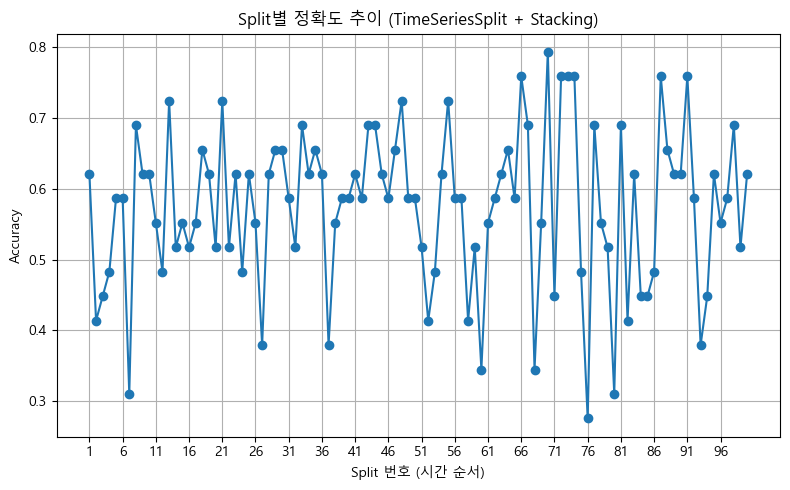

In [16]:
with open('./Model_5_preprocessed_Data/df.pickle',"rb") as f:
    df = pickle.load(f)

df = add_betting_odds(df, 'betman_games_수정.xlsx')
df = df.dropna(subset=['배당률'])
df = onehot_encode_features(df, columns=['팀명', '상대팀', '경기장'])


features = [
    '팀명_인코딩', '경기장_인코딩', '홈/원정_인코딩',
    '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
    '최근평균타율', '최근평균출루율', '배당률', '경기장_평균홈런', '경기장_평균안타', '경기장_평균득점', '상대팀_인코딩', '최근승률_상대', '최근평균득점_상대', '최근평균안타_상대', '최근평균홈런_상대', '최근평균타율_상대', '최근평균출루율_상대',
    '관중수']
#, '득점률', '출루율']

X = df[features]
y = (df['승리여부'] == '승').astype(int)

# 전처리 파이프라인
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 시계열 분할 및 반복 학습
tscv = TimeSeriesSplit(n_splits=100)
accuracies = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 전처리
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    # 스태킹 모델 준비
    base_models = create_base_models()
    stacking_model = create_stacking_classifier(base_models)

    # 모델 학습 및 평가
    stacking_model.fit(X_train_processed, y_train)
    y_pred = stacking_model.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Split {i+1}: Accuracy = {acc:.4f}")

# 정확도 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.title("Split별 정확도 추이 (TimeSeriesSplit + Stacking)")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies) + 1, max(1, len(accuracies) // 20)))
plt.grid(True)
plt.tight_layout()
print(f"average_acc : {sum(accuracies) / len(accuracies)}")
plt.show()


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2954 entries, 0 to 2953
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   날짜          2954 non-null   object 
 1   연도          2954 non-null   int64  
 2   경기장         2954 non-null   object 
 3   팀명          2954 non-null   object 
 4   홈/원정        2954 non-null   object 
 5   타수          2954 non-null   int64  
 6   안타          2954 non-null   int64  
 7   득점          2954 non-null   int64  
 8   2루타         2954 non-null   int64  
 9   3루타         2954 non-null   int64  
 10  홈런          2954 non-null   int64  
 11  볼넷          2954 non-null   int64  
 12  사구          2954 non-null   int64  
 13  희생플라이       2954 non-null   int64  
 14  타점          2954 non-null   int64  
 15  병살타         2954 non-null   int64  
 16  폭투          2954 non-null   int64  
 17  관중수         2954 non-null   int64  
 18  타율          2954 non-null   float64
 19  출루율         2954 non-null  

In [18]:
# features = [
#     '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
#     '최근평균타율', '최근평균출루율', '배당률', '경기장_평균홈런', '경기장_평균안타', '경기장_평균득점', '상대팀_인코딩', '최근승률_상대', '최근평균득점_상대', '최근평균안타_상대', '최근평균홈런_상대', '최근평균타율_상대', '최근평균출루율_상대',
#     '팀명_KT', '팀명_LG', '팀명_NC', '팀명_SSG', '팀명_두산', '팀명_롯데', '팀명_삼성', '팀명_키움', '팀명_한화',
#     '상대팀_KT', '상대팀_LG', '상대팀_NC', '상대팀_SSG', '상대팀_두산', '상대팀_롯데', '상대팀_삼성', '상대팀_키움', '상대팀_한화',
#     '경기장_광주', '경기장_대구', '경기장_대전', '경기장_대전(신)', '경기장_문학', '경기장_사직', '경기장_수원', '경기장_울산', '경기장_잠실', '경기장_창원', '경기장_청주', '경기장_포항']

# 최적 하이퍼 파라미터 찾기 (Stacking Model)

In [19]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# import xgboost as xgb
# import lightgbm as lgb

# # 전처리 파이프라인
# preprocessing = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# # TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=3)

# # X, y 준비
# X = df[features]
# y = (df['승리여부'] == '승').astype(int)

# def objective(trial):
#     # 하이퍼파라미터 샘플링
#     xgb_params = {
#         'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.3),
#         'max_depth': trial.suggest_int('xgb_max_depth', 3, 7),
#         'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 300),
#         'random_state': 42,
#         'use_label_encoder': False,
#         'eval_metric': 'logloss'
#     }

#     lgb_params = {
#         'learning_rate': trial.suggest_float('lgb_lr', 0.01, 0.3),
#         'max_depth': trial.suggest_int('lgb_max_depth', 3, 7),
#         'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 300),
#         'random_state': 42
#     }

#     rf_params = {
#         'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
#         'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
#         'n_estimators': trial.suggest_int('rf_n_estimators', 100, 300),
#         'random_state': 42
#     }

#     # 모델 정의
#     base_models = {
#         'xgb': xgb.XGBClassifier(**xgb_params),
#         'lgb': lgb.LGBMClassifier(**lgb_params),
#         'rf': RandomForestClassifier(**rf_params)
#     }

#     from sklearn.ensemble import StackingClassifier
#     estimators = [(name, model) for name, model in base_models.items()]
#     stacking_model = StackingClassifier(
#         estimators=estimators,
#         final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
#         passthrough=True
#     )

#     scores = []
#     for train_index, test_index in tscv.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         # 전처리
#         X_train_proc = preprocessing.fit_transform(X_train)
#         X_test_proc = preprocessing.transform(X_test)

#         stacking_model.fit(X_train_proc, y_train)
#         preds = stacking_model.predict(X_test_proc)
#         acc = accuracy_score(y_test, preds)
#         scores.append(acc)

#     return sum(scores) / len(scores)

# # Optuna 실행
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # 결과 출력
# print("Best trial:")
# print(f"  Value: {study.best_trial.value}")
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


In [20]:
# Best trial:
#   Value: 0.5636856368563686
#   Params: 
#     xgb_lr: 0.07177600548828808
#     xgb_max_depth: 7
#     xgb_n_estimators: 216
#     lgb_lr: 0.2349130282157283
#     lgb_max_depth: 4
#     lgb_n_estimators: 117
#     rf_max_depth: 5
#     rf_min_samples_split: 3
#     rf_n_estimators: 135

In [21]:
X_train

,팀명_인코딩,경기장_인코딩,홈/원정_인코딩,최근승률,최근평균득점,최근평균안타,최근평균홈런,최근평균타율,최근평균출루율,배당률,...,경기장_평균안타,경기장_평균득점,상대팀_인코딩,최근승률_상대,최근평균득점_상대,최근평균안타_상대,최근평균홈런_상대,최근평균타율_상대,최근평균출루율_상대,관중수
0,9,2,1,0.6,5.2,10.4,1.0,0.296296,0.341333,1.57,...,9.844298,5.468567,3,0.6,3.2,8.9,0.3,0.262537,0.315068,24000
1,3,2,0,0.6,3.2,8.9,0.3,0.262537,0.315068,2.0,...,9.844298,5.468567,9,0.6,5.2,10.4,1.0,0.296296,0.341333,24000
2,8,11,0,0.5,4.3,9.8,0.7,0.282421,0.344737,1.9,...,9.109484,4.683054,7,0.4,3.5,9.0,1.0,0.263158,0.315217,23750
3,7,11,1,0.4,3.5,9.0,1.0,0.263158,0.315217,1.64,...,9.109484,4.683054,8,0.5,4.3,9.8,0.7,0.282421,0.344737,23750
4,0,7,0,0.7,5.1,9.5,0.8,0.279412,0.350133,2.15,...,9.154114,5.107392,5,0.4,4.8,8.3,1.6,0.241983,0.321149,23000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,5,9,0,0.3,4.8,8.4,0.5,0.246334,0.325459,1.75,...,9.784519,5.149930,1,0.6,5.1,9.5,0.7,0.283582,0.370079,7815
2921,10,0,1,0.3,3.0,7.8,0.4,0.228739,0.291105,2.68,...,9.437973,4.866112,7,0.3,4.2,8.6,0.6,0.258258,0.339572,7690
2922,7,0,0,0.3,4.2,8.6,0.6,0.258258,0.339572,1.31,...,9.437973,4.866112,10,0.3,3.0,7.8,0.4,0.228739,0.291105,7690
2923,3,11,0,0.3,3.5,6.0,0.8,0.199336,0.289086,2.77,...,9.109484,4.683054,2,0.6,5.1,8.8,0.8,0.269113,0.391858,19325


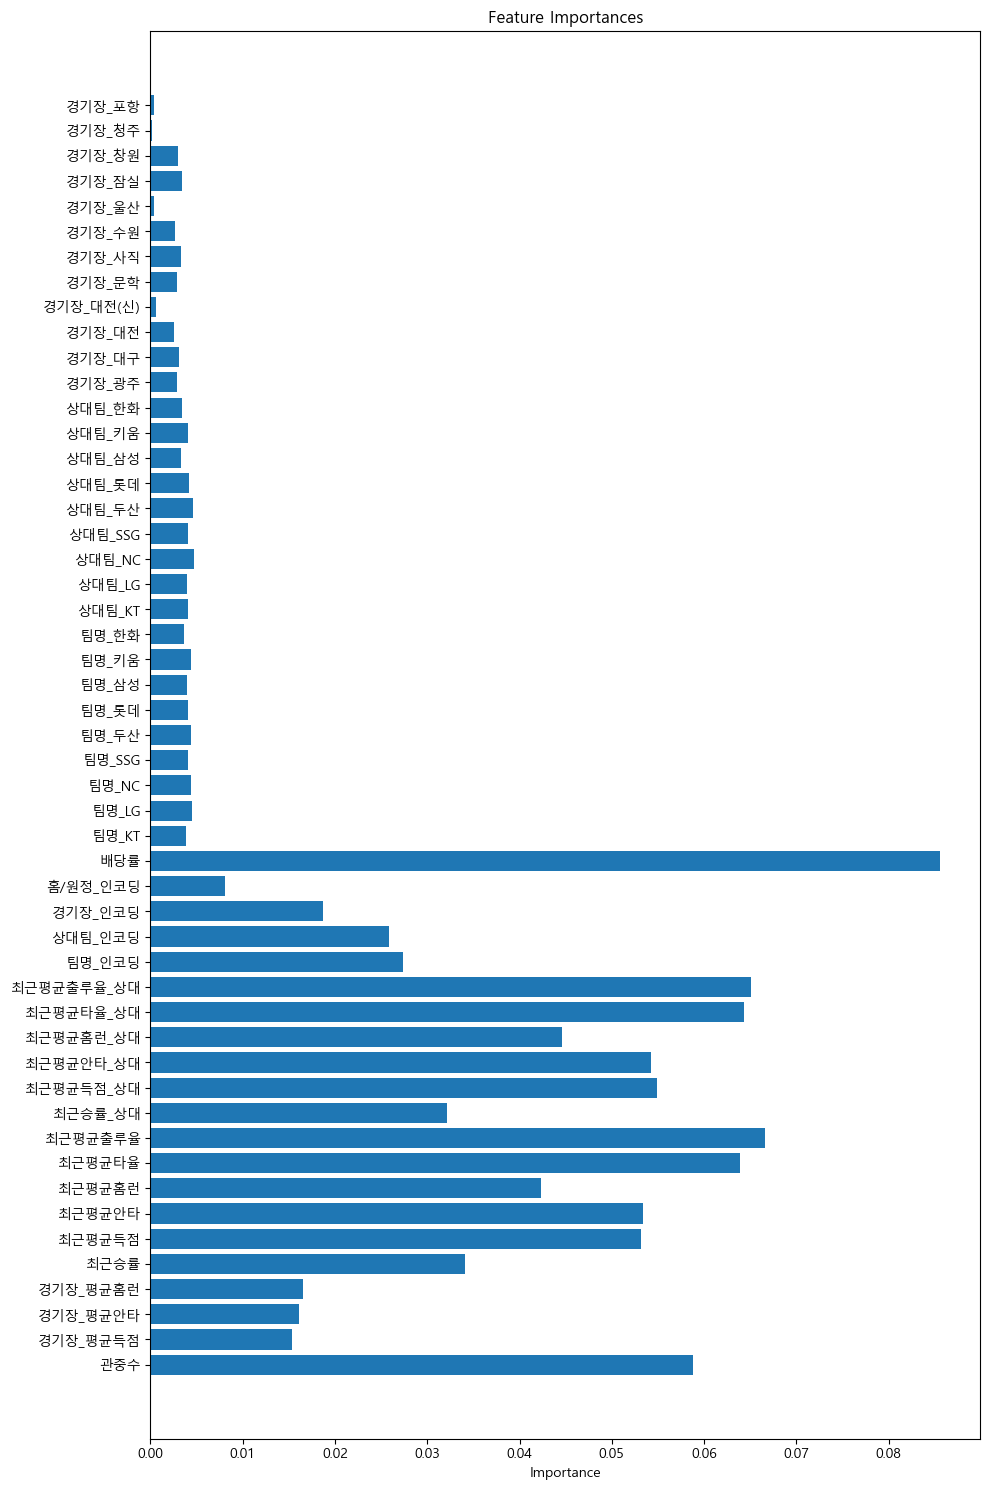

In [31]:
import matplotlib.pyplot as plt

column_list = df.columns.tolist()
뺄것 = ['날짜', '연도', '경기장', '팀명', '홈/원정', '상대팀', '승리여부', '득점률', '타점', '득점', '안타', '경기ID', '단타율', '장타율', '출루율', '타율', '폭투', '병살타', '희생플라이', '사구', '볼넷', '홈런', '3루타', '2루타', '타수']
for i in 뺄것:
    column_list.remove(i)

X = df[column_list]
y = (df['승리여부'] == '승').astype(int)

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_names = X.columns

# 중요도 시각화
plt.figure(figsize=(10, 15))
plt.barh(feature_names, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# 모델 비교

# Model_1 (LightGBM)

[LightGBM] [Info] Number of positive: 26, number of negative: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481481 -> initscore=-0.074108
[LightGBM] [Info] Start training from score -0.074108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

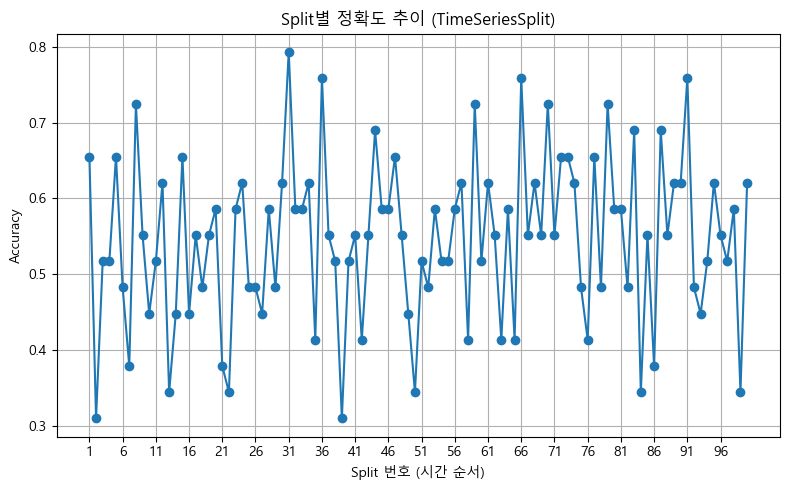

In [23]:
from lightgbm import LGBMClassifier

accuracies = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    model = LGBMClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"[LightGBM] Split {i+1}: Accuracy = {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.title("Split별 정확도 추이 (TimeSeriesSplit)")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies) + 1, max(1, len(accuracies) // 20)))
plt.grid(True)
plt.tight_layout()
print(f"average_acc : {sum(accuracies) / len(accuracies)}")
plt.show()


# Model_2 (Logistic Regression)

[LogReg] Split 1: Accuracy = 0.6552
[LogReg] Split 2: Accuracy = 0.3793
[LogReg] Split 3: Accuracy = 0.3793
[LogReg] Split 4: Accuracy = 0.5862
[LogReg] Split 5: Accuracy = 0.6207
[LogReg] Split 6: Accuracy = 0.5517
[LogReg] Split 7: Accuracy = 0.2759
[LogReg] Split 8: Accuracy = 0.6207
[LogReg] Split 9: Accuracy = 0.5862
[LogReg] Split 10: Accuracy = 0.5862
[LogReg] Split 11: Accuracy = 0.5517
[LogReg] Split 12: Accuracy = 0.4828
[LogReg] Split 13: Accuracy = 0.7241
[LogReg] Split 14: Accuracy = 0.4483
[LogReg] Split 15: Accuracy = 0.4828
[LogReg] Split 16: Accuracy = 0.5517
[LogReg] Split 17: Accuracy = 0.4828
[LogReg] Split 18: Accuracy = 0.4483
[LogReg] Split 19: Accuracy = 0.6897
[LogReg] Split 20: Accuracy = 0.4138
[LogReg] Split 21: Accuracy = 0.5862
[LogReg] Split 22: Accuracy = 0.6552
[LogReg] Split 23: Accuracy = 0.5862
[LogReg] Split 24: Accuracy = 0.4828
[LogReg] Split 25: Accuracy = 0.4138
[LogReg] Split 26: Accuracy = 0.5862
[LogReg] Split 27: Accuracy = 0.3448
[LogReg] S

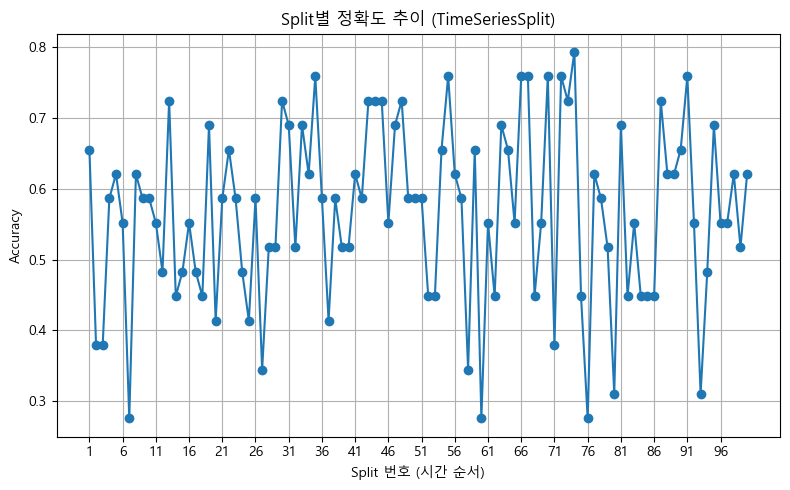

In [24]:
from sklearn.linear_model import LogisticRegression

accuracies = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"[LogReg] Split {i+1}: Accuracy = {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.title("Split별 정확도 추이 (TimeSeriesSplit)")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies) + 1, max(1, len(accuracies) // 20)))
plt.grid(True)
plt.tight_layout()
print(f"average_acc : {sum(accuracies) / len(accuracies)}")
plt.show()


# 딥러닝 코드

# Model_3 (MLP)

Split 1: Accuracy = 0.5862
Split 2: Accuracy = 0.3793
Split 3: Accuracy = 0.5172
Split 4: Accuracy = 0.5172
Split 5: Accuracy = 0.6207
Split 6: Accuracy = 0.5862
Split 7: Accuracy = 0.4138
Split 8: Accuracy = 0.3793
Split 9: Accuracy = 0.4138
Split 10: Accuracy = 0.5172
Split 11: Accuracy = 0.3793
Split 12: Accuracy = 0.6552
Split 13: Accuracy = 0.3793
Split 14: Accuracy = 0.4828
Split 15: Accuracy = 0.5172
Split 16: Accuracy = 0.5517
Split 17: Accuracy = 0.5517
Split 18: Accuracy = 0.3793
Split 19: Accuracy = 0.6552
Split 20: Accuracy = 0.3793
Split 21: Accuracy = 0.5517
Split 22: Accuracy = 0.5172
Split 23: Accuracy = 0.6897
Split 24: Accuracy = 0.5172
Split 25: Accuracy = 0.3103
Split 26: Accuracy = 0.5172
Split 27: Accuracy = 0.4138
Split 28: Accuracy = 0.5517
Split 29: Accuracy = 0.6207
Split 30: Accuracy = 0.5862
Split 31: Accuracy = 0.5862
Split 32: Accuracy = 0.5862
Split 33: Accuracy = 0.5862
Split 34: Accuracy = 0.4828
Split 35: Accuracy = 0.6552
Split 36: Accuracy = 0.7241
S

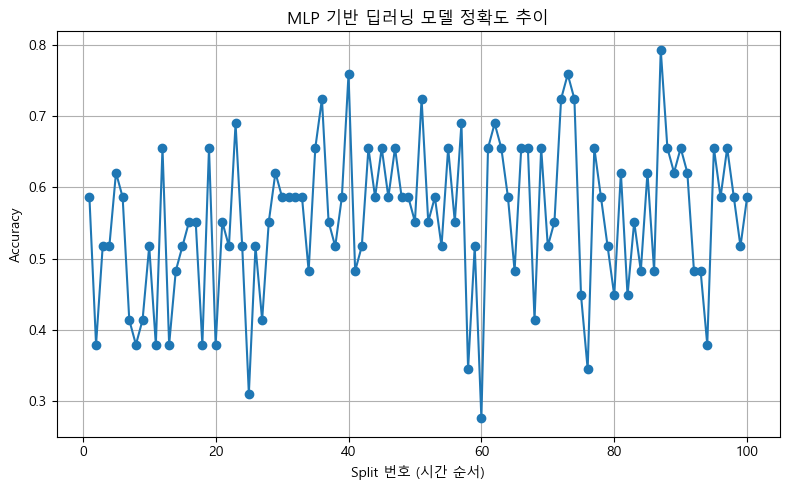

In [25]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
with open('./Model_5_preprocessed_Data/df.pickle', "rb") as f:
    df = pickle.load(f)

df = add_betting_odds(df, 'betman_games_수정.xlsx')
df = df.dropna(subset=['배당률'])
df = onehot_encode_features(df, columns=['팀명', '상대팀', '경기장'])

features = [
    '팀명_인코딩', '경기장_인코딩', '홈/원정_인코딩',
    '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
    '최근평균타율', '최근평균출루율', '배당률', '경기장_평균홈런', '경기장_평균안타', '경기장_평균득점',
    '상대팀_인코딩', '최근승률_상대', '최근평균득점_상대', '최근평균안타_상대', '최근평균홈런_상대', '최근평균타율_상대', '최근평균출루율_상대',
    '관중수'
]

X = df[features]
y = (df['승리여부'] == '승').astype(int)

# PyTorch 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 평가 루프
def train_and_evaluate_model(ModelClass, input_dim, device, n_splits=100, epochs=20, batch_size=32):
    preprocessing = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    tscv = TimeSeriesSplit(n_splits=n_splits)
    accuracies = []

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_processed = preprocessing.fit_transform(X_train)
        X_test_processed = preprocessing.transform(X_test)

        # Tensor로 변환
        X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
        X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        model = ModelClass(input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        # 학습 루프
        model.train()
        for epoch in range(epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # 평가
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_test_tensor)
            y_pred_labels = (y_pred_probs >= 0.5).int().cpu().numpy()
            acc = accuracy_score(y_test.values, y_pred_labels)
            accuracies.append(acc)
            print(f"Split {i+1}: Accuracy = {acc:.4f}")

    return accuracies

# 실행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[1]
accuracies_mlp = train_and_evaluate_model(MLP, input_dim, device)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies_mlp) + 1), accuracies_mlp, marker='o', linestyle='-')
plt.title("MLP 기반 딥러닝 모델 정확도 추이")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
print(f"average_acc : {sum(accuracies_mlp) / len(accuracies_mlp)}")
plt.show()


# Model_4 (LSTM)

Split 1: Accuracy = 0.5172
Split 2: Accuracy = 0.3448
Split 3: Accuracy = 0.4483
Split 4: Accuracy = 0.5517
Split 5: Accuracy = 0.6897
Split 6: Accuracy = 0.4138
Split 7: Accuracy = 0.3793
Split 8: Accuracy = 0.4138
Split 9: Accuracy = 0.3793
Split 10: Accuracy = 0.4483
Split 11: Accuracy = 0.3793
Split 12: Accuracy = 0.4828
Split 13: Accuracy = 0.5172
Split 14: Accuracy = 0.4828
Split 15: Accuracy = 0.5517
Split 16: Accuracy = 0.6207
Split 17: Accuracy = 0.5172
Split 18: Accuracy = 0.4483
Split 19: Accuracy = 0.7241
Split 20: Accuracy = 0.4138
Split 21: Accuracy = 0.5862
Split 22: Accuracy = 0.6207
Split 23: Accuracy = 0.6207
Split 24: Accuracy = 0.5517
Split 25: Accuracy = 0.4138
Split 26: Accuracy = 0.4828
Split 27: Accuracy = 0.2759
Split 28: Accuracy = 0.7931
Split 29: Accuracy = 0.5517
Split 30: Accuracy = 0.6897
Split 31: Accuracy = 0.5172
Split 32: Accuracy = 0.5862
Split 33: Accuracy = 0.6207
Split 34: Accuracy = 0.6207
Split 35: Accuracy = 0.6207
Split 36: Accuracy = 0.6552
S

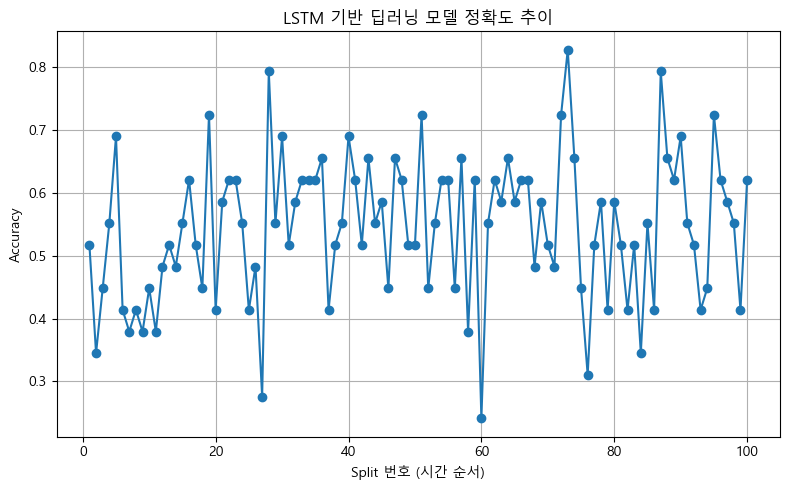

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 입력 shape: [batch_size, input_dim] → [batch_size, 1, input_dim]
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)              # [batch_size, 1, hidden_dim]
        out = out[:, -1, :]                # 마지막 시점
        out = self.fc(out)
        return out


accuracies_lstm = train_and_evaluate_model(LSTMModel, input_dim, device)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies_lstm) + 1), accuracies_lstm, marker='o', linestyle='-')
plt.title("LSTM 기반 딥러닝 모델 정확도 추이")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
print(f"average_acc : {sum(accuracies_lstm) / len(accuracies_lstm)}")
plt.show()


# 베팅 모형

In [27]:
# initial_money = 100000
# money = initial_money
# profits = [money]

# min_train_size = 100
# bet_threshold = 0.6
# bet_amount = 1000

# for i in range(min_train_size, len(df) - 1):
#     X_train = X.iloc[:i]
#     y_train = y.iloc[:i]
#     X_test = X.iloc[i:i+1]
#     y_test = y.iloc[i:i+1]
#     odds = df.iloc[i]['배당률']
#     game_date = df.iloc[i].get('날짜', i)  # '날짜'가 있으면 출력용으로 활용

#     # 전처리
#     X_train_processed = preprocessing.fit_transform(X_train)
#     X_test_processed = preprocessing.transform(X_test)

#     # 모델 생성
#     base_models = create_base_models()
#     stacking_model = create_stacking_classifier(base_models)
#     stacking_model.fit(X_train_processed, y_train)

#     # 확률 예측
#     prob = stacking_model.predict_proba(X_test_processed)[0, 1]
#     pred = int(prob >= bet_threshold)
#     true = y_test.values[0]

#     # 베팅 로직
#     if prob >= bet_threshold:
#         if true == 1:
#             win_amount = odds * bet_amount
#             money += win_amount - bet_amount
#             result = f"✅ 승! +{win_amount - bet_amount:.0f}원"
#         else:
#             money -= bet_amount
#             result = f"❌ 패! -{bet_amount}원"
#         bet_status = "베팅함"
#     else:
#         result = "❎ 베팅 안함"
#         bet_status = "스킵"

#     profits.append(money)

#     # 중간 출력 (10경기마다 한 번)
#     if (i - min_train_size) % 10 == 0 or prob >= 0.9:
#         print(f"[경기 {i}] 날짜: {game_date}, 예측확률: {prob:.3f}, 실제결과: {true}, 배당률: {odds}, 베팅: {bet_status}, {result}, 누적자본: {money:,.0f}원")

# # 결과 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(profits, label="누적 수익")
# plt.axhline(initial_money, color='red', linestyle='--', label="초기 자본")
# plt.xlabel("경기 수")
# plt.ylabel("자본")
# plt.title("경기 단위 베팅 전략 수익률 시뮬레이션")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f"\n최종 수익률: {(money - initial_money) / initial_money * 100:.2f}%")
# print(f"최종 자본: {money:,.0f}원")


[경기 100] 날짜: 2023-04-14, 예측확률: 0.182, 실제결과: 0, 배당률: 1.79, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,000원
[경기 101] 날짜: 2023-04-14, 예측확률: 0.956, 실제결과: 1, 배당률: 1.36, 베팅: 베팅함, ✅ 승! +360원, 누적자본: 100,360원
[경기 110] 날짜: 2023-04-15, 예측확률: 0.724, 실제결과: 0, 배당률: 1.57, 베팅: 베팅함, ❌ 패! -1000원, 누적자본: 98,090원
[경기 120] 날짜: 2023-04-16, 예측확률: 0.680, 실제결과: 0, 배당률: 1.5, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 96,750원
[경기 130] 날짜: 2023-04-18, 예측확률: 0.571, 실제결과: 0, 배당률: 1.56, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 95,750원
[경기 140] 날짜: 2023-04-19, 예측확률: 0.597, 실제결과: 0, 배당률: 1.66, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 96,500원
[경기 150] 날짜: 2023-04-20, 예측확률: 0.717, 실제결과: 0, 배당률: 1.96, 베팅: 베팅함, ❌ 패! -1000원, 누적자본: 94,500원
[경기 160] 날짜: 2023-04-21, 예측확률: 0.714, 실제결과: 1, 배당률: 1.7, 베팅: 베팅함, ✅ 승! +700원, 누적자본: 96,070원
[경기 170] 날짜: 2023-04-22, 예측확률: 0.598, 실제결과: 0, 배당률: 1.43, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 95,570원
[경기 180] 날짜: 2023-04-23, 예측확률: 0.605, 실제결과: 0, 배당률: 1.57, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 95,240원
[경기 190] 날짜: 2023-04-25, 예측확률: 0.683, 실제결과: 1, 배당률: 1.54, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 95,240원
[경기

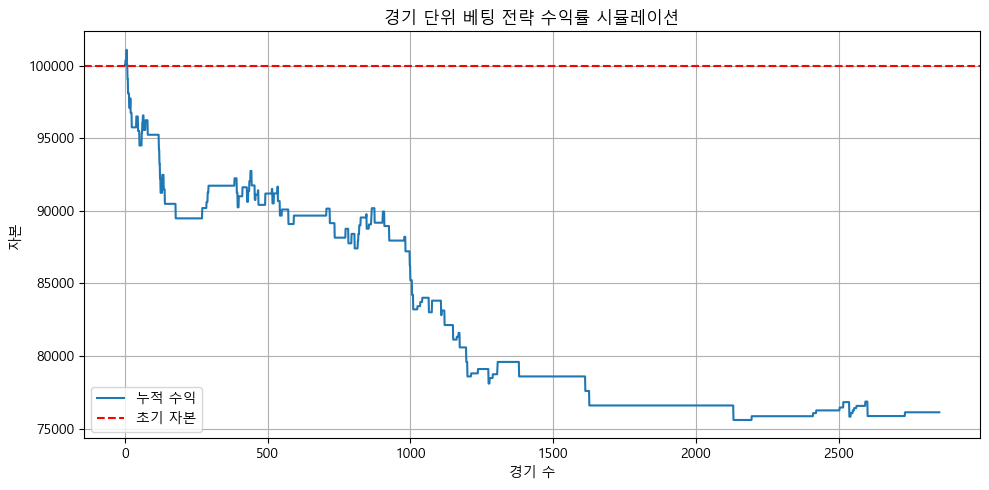


최종 수익률: -23.88%
최종 자본: 76,120원


In [28]:
initial_money = 100000
money = initial_money
profits = [money]

min_train_size = 100
bet_threshold = 0.7
bet_amount = 1000

for i in range(min_train_size, len(df) - 1):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]
    odds = df.iloc[i]['배당률']
    game_date = df.iloc[i].get('날짜', i)  # '날짜'가 있으면 출력용으로 활용

    # 전처리
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    # 모델 생성
    base_models = create_base_models()
    stacking_model = create_stacking_classifier(base_models)
    stacking_model.fit(X_train_processed, y_train)

    # 확률 예측
    prob = stacking_model.predict_proba(X_test_processed)[0, 1]
    pred = int(prob >= bet_threshold)
    true = y_test.values[0]

    # 베팅 로직
    if prob >= bet_threshold:
        if true == 1:
            win_amount = odds * bet_amount
            money += win_amount - bet_amount
            result = f"✅ 승! +{win_amount - bet_amount:.0f}원"
        else:
            money -= bet_amount
            result = f"❌ 패! -{bet_amount}원"
        bet_status = "베팅함"
    else:
        result = "❎ 베팅 안함"
        bet_status = "스킵"

    profits.append(money)

    # 중간 출력 (10경기마다 한 번)
    if (i - min_train_size) % 10 == 0 or prob >= 0.9:
        print(f"[경기 {i}] 날짜: {game_date}, 예측확률: {prob:.3f}, 실제결과: {true}, 배당률: {odds}, 베팅: {bet_status}, {result}, 누적자본: {money:,.0f}원")

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(profits, label="누적 수익")
plt.axhline(initial_money, color='red', linestyle='--', label="초기 자본")
plt.xlabel("경기 수")
plt.ylabel("자본")
plt.title("경기 단위 베팅 전략 수익률 시뮬레이션")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n최종 수익률: {(money - initial_money) / initial_money * 100:.2f}%")
print(f"최종 자본: {money:,.0f}원")


[경기 100] 날짜: 2023-04-14, 예측확률: 0.182, 실제결과: 0, 배당률: 1.79, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,000원
[경기 101] 날짜: 2023-04-14, 예측확률: 0.956, 실제결과: 1, 배당률: 1.36, 베팅: 베팅함, ✅ 승! +360원, 누적자본: 100,360원
[경기 110] 날짜: 2023-04-15, 예측확률: 0.724, 실제결과: 0, 배당률: 1.57, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 120] 날짜: 2023-04-16, 예측확률: 0.680, 실제결과: 0, 배당률: 1.5, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,020원
[경기 130] 날짜: 2023-04-18, 예측확률: 0.571, 실제결과: 0, 배당률: 1.56, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 140] 날짜: 2023-04-19, 예측확률: 0.597, 실제결과: 0, 배당률: 1.66, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 150] 날짜: 2023-04-20, 예측확률: 0.717, 실제결과: 0, 배당률: 1.96, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 160] 날짜: 2023-04-21, 예측확률: 0.714, 실제결과: 1, 배당률: 1.7, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 170] 날짜: 2023-04-22, 예측확률: 0.598, 실제결과: 0, 배당률: 1.43, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 180] 날짜: 2023-04-23, 예측확률: 0.605, 실제결과: 0, 배당률: 1.57, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 190] 날짜: 2023-04-25, 예측확률: 0.683, 실제결과: 1, 배당률: 1.54, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 99,020원
[경기 200] 날짜: 20

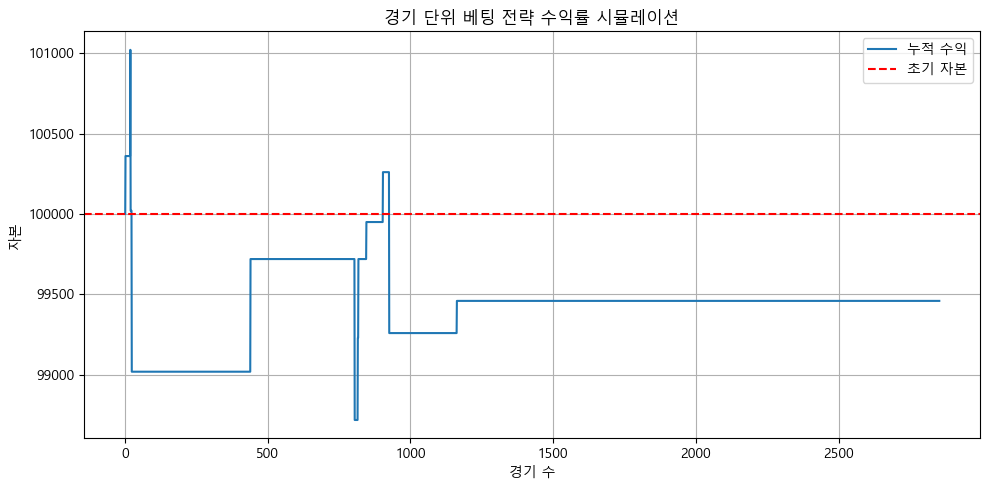


최종 수익률: -0.54%
최종 자본: 99,460원


In [29]:
initial_money = 100000
money = initial_money
profits = [money]

min_train_size = 100
bet_threshold = 0.8
bet_amount = 1000

for i in range(min_train_size, len(df) - 1):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]
    odds = df.iloc[i]['배당률']
    game_date = df.iloc[i].get('날짜', i)  # '날짜'가 있으면 출력용으로 활용

    # 전처리
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    # 모델 생성
    base_models = create_base_models()
    stacking_model = create_stacking_classifier(base_models)
    stacking_model.fit(X_train_processed, y_train)

    # 확률 예측
    prob = stacking_model.predict_proba(X_test_processed)[0, 1]
    pred = int(prob >= bet_threshold)
    true = y_test.values[0]

    # 베팅 로직
    if prob >= bet_threshold:
        if true == 1:
            win_amount = odds * bet_amount
            money += win_amount - bet_amount
            result = f"✅ 승! +{win_amount - bet_amount:.0f}원"
        else:
            money -= bet_amount
            result = f"❌ 패! -{bet_amount}원"
        bet_status = "베팅함"
    else:
        result = "❎ 베팅 안함"
        bet_status = "스킵"

    profits.append(money)

    # 중간 출력 (10경기마다 한 번)
    if (i - min_train_size) % 10 == 0 or prob >= 0.9:
        print(f"[경기 {i}] 날짜: {game_date}, 예측확률: {prob:.3f}, 실제결과: {true}, 배당률: {odds}, 베팅: {bet_status}, {result}, 누적자본: {money:,.0f}원")

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(profits, label="누적 수익")
plt.axhline(initial_money, color='red', linestyle='--', label="초기 자본")
plt.xlabel("경기 수")
plt.ylabel("자본")
plt.title("경기 단위 베팅 전략 수익률 시뮬레이션")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n최종 수익률: {(money - initial_money) / initial_money * 100:.2f}%")
print(f"최종 자본: {money:,.0f}원")


[경기 100] 날짜: 2023-04-14, 예측확률: 0.182, 실제결과: 0, 배당률: 1.79, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,000원
[경기 101] 날짜: 2023-04-14, 예측확률: 0.956, 실제결과: 1, 배당률: 1.36, 베팅: 베팅함, ✅ 승! +360원, 누적자본: 100,360원
[경기 110] 날짜: 2023-04-15, 예측확률: 0.724, 실제결과: 0, 배당률: 1.57, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 120] 날짜: 2023-04-16, 예측확률: 0.680, 실제결과: 0, 배당률: 1.5, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 130] 날짜: 2023-04-18, 예측확률: 0.571, 실제결과: 0, 배당률: 1.56, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 140] 날짜: 2023-04-19, 예측확률: 0.597, 실제결과: 0, 배당률: 1.66, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 150] 날짜: 2023-04-20, 예측확률: 0.717, 실제결과: 0, 배당률: 1.96, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 160] 날짜: 2023-04-21, 예측확률: 0.714, 실제결과: 1, 배당률: 1.7, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 170] 날짜: 2023-04-22, 예측확률: 0.598, 실제결과: 0, 배당률: 1.43, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 180] 날짜: 2023-04-23, 예측확률: 0.605, 실제결과: 0, 배당률: 1.57, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 190] 날짜: 2023-04-25, 예측확률: 0.683, 실제결과: 1, 배당률: 1.54, 베팅: 스킵, ❎ 베팅 안함, 누적자본: 100,360원
[경기 200]

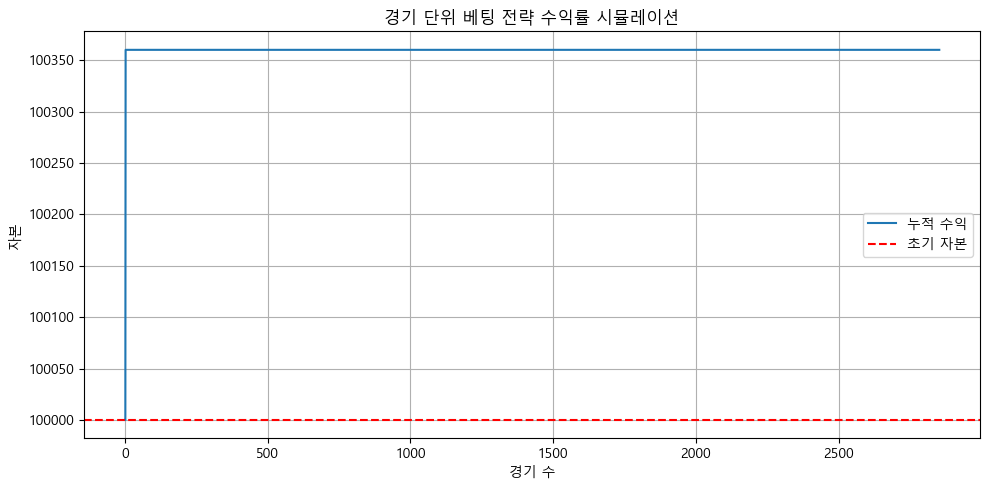


최종 수익률: 0.36%
최종 자본: 100,360원


In [30]:
initial_money = 100000
money = initial_money
profits = [money]

min_train_size = 100
bet_threshold = 0.9
bet_amount = 1000

for i in range(min_train_size, len(df) - 1):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]
    odds = df.iloc[i]['배당률']
    game_date = df.iloc[i].get('날짜', i)  # '날짜'가 있으면 출력용으로 활용

    # 전처리
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    # 모델 생성
    base_models = create_base_models()
    stacking_model = create_stacking_classifier(base_models)
    stacking_model.fit(X_train_processed, y_train)

    # 확률 예측
    prob = stacking_model.predict_proba(X_test_processed)[0, 1]
    pred = int(prob >= bet_threshold)
    true = y_test.values[0]

    # 베팅 로직
    if prob >= bet_threshold:
        if true == 1:
            win_amount = odds * bet_amount
            money += win_amount - bet_amount
            result = f"✅ 승! +{win_amount - bet_amount:.0f}원"
        else:
            money -= bet_amount
            result = f"❌ 패! -{bet_amount}원"
        bet_status = "베팅함"
    else:
        result = "❎ 베팅 안함"
        bet_status = "스킵"

    profits.append(money)

    # 중간 출력 (10경기마다 한 번)
    if (i - min_train_size) % 10 == 0 or prob >= 0.9:
        print(f"[경기 {i}] 날짜: {game_date}, 예측확률: {prob:.3f}, 실제결과: {true}, 배당률: {odds}, 베팅: {bet_status}, {result}, 누적자본: {money:,.0f}원")

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(profits, label="누적 수익")
plt.axhline(initial_money, color='red', linestyle='--', label="초기 자본")
plt.xlabel("경기 수")
plt.ylabel("자본")
plt.title("경기 단위 베팅 전략 수익률 시뮬레이션")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n최종 수익률: {(money - initial_money) / initial_money * 100:.2f}%")
print(f"최종 자본: {money:,.0f}원")


[경기 50] 날짜: 2023-04-14, 선택 배당: 1.36, 베팅 팀: KT, ✅ 승! +7200원, 누적자본: 107,200원
[경기 55] 날짜: 2023-04-15, 선택 배당: 1.57, 베팅 팀: SSG, ❌ 패! -16998원, 누적자본: 67,992원
[경기 60] 날짜: 2023-04-16, 선택 배당: 1.50, 베팅 팀: LG, ✅ 승! +3836원, 누적자본: 42,199원
[경기 65] 날짜: 2023-04-18, 선택 배당: 1.56, 베팅 팀: LG, ✅ 승! +2609원, 누적자본: 25,900원
[경기 70] 날짜: 2023-04-19, 선택 배당: 1.66, 베팅 팀: 두산, ❌ 패! -6139원, 누적자본: 24,555원
[경기 75] 날짜: 2023-04-20, 선택 배당: 1.96, 베팅 팀: KIA, ✅ 승! +2684원, 누적자본: 16,665원
[경기 80] 날짜: 2023-04-21, 선택 배당: 1.70, 베팅 팀: 두산, ✅ 승! +1748원, 누적자본: 14,234원
[경기 85] 날짜: 2023-04-22, 선택 배당: 1.43, 베팅 팀: KT, ❌ 패! -3210원, 누적자본: 12,838원
[경기 90] 날짜: 2023-04-23, 선택 배당: 1.57, 베팅 팀: KT, ❌ 패! -2161원, 누적자본: 8,644원
[경기 95] 날짜: 2023-04-25, 선택 배당: 1.54, 베팅 팀: LG, ✅ 승! +1052원, 누적자본: 10,797원
[경기 100] 날짜: 2023-04-26, 선택 배당: 1.57, 베팅 팀: 롯데, ❌ 패! -1267원, 누적자본: 5,068원
[경기 105] 날짜: 2023-04-27, 선택 배당: 2.02, 베팅 팀: KT, ❌ 패! -775원, 누적자본: 3,100원
[경기 110] 날짜: 2023-04-28, 선택 배당: 1.68, 베팅 팀: 롯데, ✅ 승! +462원, 누적자본: 3,856원
[경기 115] 날짜: 2023-04-30, 선택 배당: 1.45,

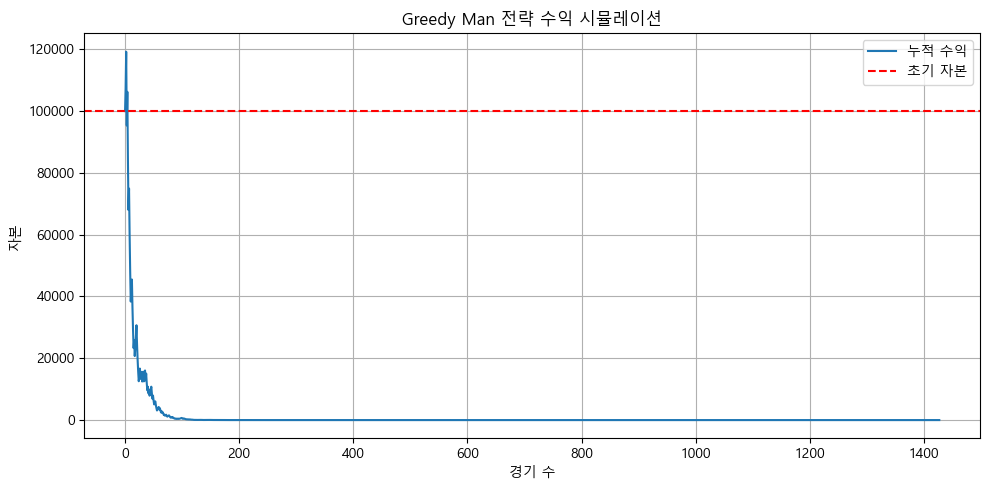


최종 수익률: -100.00%
⚖️ 샤프 비율: -2.512
📉 최대 낙폭 비율: 100.00%
최종 자본: 0원


In [36]:
initial_money = 100000
money = initial_money
profits = [money]
bet_ratio = 0.2

for i in range(min_train_size, len(df) - 1, 2):  # 2줄씩 읽기
    team1 = df.iloc[i]
    team2 = df.iloc[i + 1]

    # 홈/원정 구분
    if team1['홈/원정'] == '홈':
        home = team1
        away = team2
    else:
        home = team2
        away = team1

    home_odds = home['배당률']
    away_odds = away['배당률']
    game_date = home['날짜']

    # 낮은 배당 쪽 선택
    if home_odds < away_odds:
        bet_team = home
        selected_odds = home_odds
        bet_result = int(home['득점'] > away['득점'])
    else:
        bet_team = away
        selected_odds = away_odds
        bet_result = int(away['득점'] > home['득점'])

    bet_amount = money * bet_ratio

    if bet_result == 1:
        win_amount = selected_odds * bet_amount
        money += win_amount - bet_amount
        result = f"✅ 승! +{win_amount - bet_amount:.0f}원"
    else:
        money -= bet_amount
        result = f"❌ 패! -{bet_amount:.0f}원"

    profits.append(money)

    if (i - min_train_size) % 10 == 0:
        print(f"[경기 {i//2}] 날짜: {game_date}, 선택 배당: {selected_odds:.2f}, 베팅 팀: {bet_team['팀명']}, {result}, 누적자본: {money:,.0f}원")

# 수익 시각화
plt.figure(figsize=(10, 5))
plt.plot(profits, label="누적 수익")
plt.axhline(initial_money, color='red', linestyle='--', label="초기 자본")
plt.xlabel("경기 수")
plt.ylabel("자본")
plt.title("Greedy Man 전략 수익 시뮬레이션")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n최종 수익률: {(money - initial_money) / initial_money * 100:.2f}%")
returns = np.diff(profits) / profits[:-1]
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)  # 연율화 (하루 1경기 기준)
print(f"⚖️ 샤프 비율: {sharpe_ratio:.3f}")
cumulative_max = np.maximum.accumulate(profits)
drawdowns = (cumulative_max - profits) / cumulative_max
max_drawdown = drawdowns.max()
print(f"📉 최대 낙폭 비율: {max_drawdown * 100:.2f}%")
print(f"최종 자본: {money:,.0f}원")


[경기 50] 날짜: 2023-04-14, 선택 배당: 1.36, 베팅 팀: KT, ✅ 승! +3600원, 누적자본: 103,600원
[경기 55] 날짜: 2023-04-15, 선택 배당: 1.57, 베팅 팀: SSG, ❌ 패! -9367원, 누적자본: 84,300원
[경기 60] 날짜: 2023-04-16, 선택 배당: 1.50, 베팅 팀: LG, ✅ 승! +3229원, 누적자본: 67,818원
[경기 65] 날짜: 2023-04-18, 선택 배당: 1.56, 베팅 팀: LG, ✅ 승! +2877원, 누적자본: 54,244원
[경기 70] 날짜: 2023-04-19, 선택 배당: 1.66, 베팅 팀: 두산, ❌ 패! -5980원, 누적자본: 53,824원
[경기 75] 날짜: 2023-04-20, 선택 배당: 1.96, 베팅 팀: KIA, ✅ 승! +3978원, 누적자본: 45,413원
[경기 80] 날짜: 2023-04-21, 선택 배당: 1.70, 베팅 팀: 두산, ✅ 승! +2790원, 누적자본: 42,652원
[경기 85] 날짜: 2023-04-22, 선택 배당: 1.43, 베팅 팀: KT, ❌ 패! -4580원, 누적자본: 41,220원
[경기 90] 날짜: 2023-04-23, 선택 배당: 1.57, 베팅 팀: KT, ❌ 패! -3847원, 누적자본: 34,625원
[경기 95] 날짜: 2023-04-25, 선택 배당: 1.54, 베팅 팀: LG, ✅ 승! +2008원, 누적자본: 39,187원
[경기 100] 날짜: 2023-04-26, 선택 배당: 1.57, 베팅 팀: 롯데, ❌ 패! -3065원, 누적자본: 27,587원
[경기 105] 날짜: 2023-04-27, 선택 배당: 2.02, 베팅 팀: KT, ❌ 패! -2447원, 누적자본: 22,024원
[경기 110] 날짜: 2023-04-28, 선택 배당: 1.68, 베팅 팀: 롯데, ✅ 승! +1584원, 누적자본: 24,876원
[경기 115] 날짜: 2023-04-30, 선택 배당: 

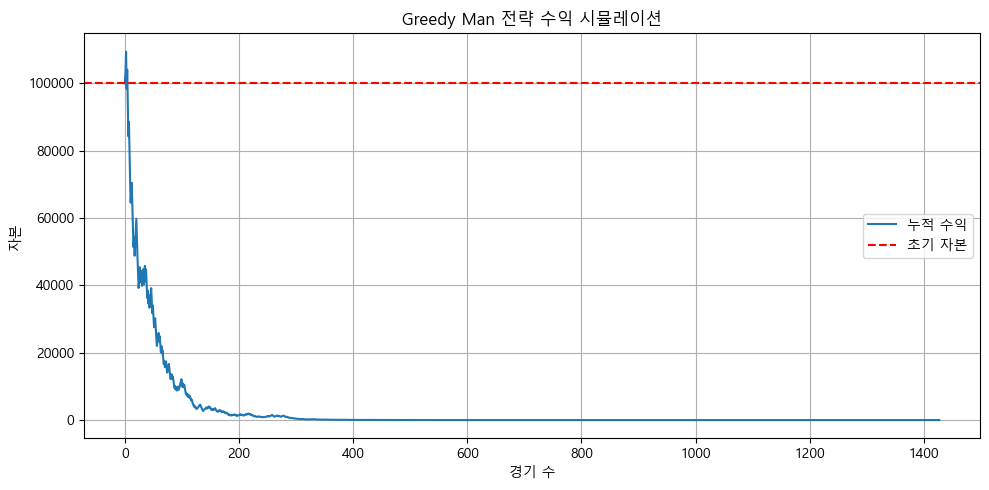


최종 수익률: -100.00%
⚖️ 샤프 비율: -2.512
📉 최대 낙폭 비율: 100.00%
최종 자본: 0원


In [37]:
initial_money = 100000
money = initial_money
profits = [money]
bet_ratio = 0.1

for i in range(min_train_size, len(df) - 1, 2):  # 2줄씩 읽기
    team1 = df.iloc[i]
    team2 = df.iloc[i + 1]

    # 홈/원정 구분
    if team1['홈/원정'] == '홈':
        home = team1
        away = team2
    else:
        home = team2
        away = team1

    home_odds = home['배당률']
    away_odds = away['배당률']
    game_date = home['날짜']

    # 낮은 배당 쪽 선택
    if home_odds < away_odds:
        bet_team = home
        selected_odds = home_odds
        bet_result = int(home['득점'] > away['득점'])
    else:
        bet_team = away
        selected_odds = away_odds
        bet_result = int(away['득점'] > home['득점'])

    bet_amount = money * bet_ratio

    if bet_result == 1:
        win_amount = selected_odds * bet_amount
        money += win_amount - bet_amount
        result = f"✅ 승! +{win_amount - bet_amount:.0f}원"
    else:
        money -= bet_amount
        result = f"❌ 패! -{bet_amount:.0f}원"

    profits.append(money)

    if (i - min_train_size) % 10 == 0:
        print(f"[경기 {i//2}] 날짜: {game_date}, 선택 배당: {selected_odds:.2f}, 베팅 팀: {bet_team['팀명']}, {result}, 누적자본: {money:,.0f}원")

# 수익 시각화
plt.figure(figsize=(10, 5))
plt.plot(profits, label="누적 수익")
plt.axhline(initial_money, color='red', linestyle='--', label="초기 자본")
plt.xlabel("경기 수")
plt.ylabel("자본")
plt.title("Greedy Man 전략 수익 시뮬레이션")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n최종 수익률: {(money - initial_money) / initial_money * 100:.2f}%")
returns = np.diff(profits) / profits[:-1]
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)  # 연율화 (하루 1경기 기준)
print(f"⚖️ 샤프 비율: {sharpe_ratio:.3f}")
cumulative_max = np.maximum.accumulate(profits)
drawdowns = (cumulative_max - profits) / cumulative_max
max_drawdown = drawdowns.max()
print(f"📉 최대 낙폭 비율: {max_drawdown * 100:.2f}%")
print(f"최종 자본: {money:,.0f}원")
